<a href="https://colab.research.google.com/github/HumaSatti/Depression-Detection-By-ML-Deep-Learning-Model/blob/main/deep_model_running_data_iteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'nurse-stress-prediction-wearable-sensors:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4110234%2F7125235%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240723%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240723T144634Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D66c2f8fae02fa20d3ff8ecb605674ed3098771c51a57b9794b19fd3bf7303cb48668d99df0f9f0654d5e2a35d53e17e79b0fdc661184c18d534cff666723679975028a47ea148987b3b3230ca5fb30cfeefb4e30481e6a88793d01cb9e81348387a437a12c1f8670a6bf491e8cc1eeb09432da471900fe1d557bc2c24d44b88a0405d1b291d7849aeccfc5890217f2cffa2c77d9020e0f0f43a1ce6eb0d961b482781dc5fb52edacf0f8070cc114acb293caad6f2035e1b0cac908e2b7b4acc125db901a79ef94a7ca9519a918721e6138fbf44c8eb4b2f803961ee886a786aa6f976af2483056ba52ab3fe0af7a151bdd6d8db0237396070941c4e3c9f6249f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 79877492 bytes downloaded
Downloaded and uncompressed: nurse-stress-prediction-wearable-sensors
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nurse-stress-prediction-wearable-sensors/merged_data.csv


In [3]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

In [4]:

from tensorflow.keras.layers import Input


In [5]:

# Load the dataset
dataset_path = '/kaggle/input/nurse-stress-prediction-wearable-sensors/merged_data.csv'
chunk_size = 10000  # Initial chunk size
data_iter = pd.read_csv(dataset_path, chunksize=chunk_size, low_memory=False, parse_dates=['datetime'])


In [6]:
# Function to preprocess chunks
def preprocess_chunk(chunk):
    chunk['month'] = chunk['datetime'].dt.month
    chunk['day'] = chunk['datetime'].dt.day
    chunk['hour'] = chunk['datetime'].dt.hour
    chunk['minute'] = chunk['datetime'].dt.minute
    chunk['second'] = chunk['datetime'].dt.second
    chunk['day_of_week'] = chunk['datetime'].dt.dayofweek
    chunk.drop(['datetime', 'id'], axis=1, inplace=True)
    return chunk

In [7]:
# Initialize data processing
first_chunk = preprocess_chunk(next(data_iter))
X = first_chunk.drop('label', axis=1)
y = first_chunk['label']

In [8]:
# Scale the features
scaler = RobustScaler()
X = scaler.fit_transform(X)

In [9]:
# Set up the strategy for TPU/CPU/GPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()  # Default strategy for CPU and GPU

In [10]:
# Build the model
with strategy.scope():
    model = Sequential([
        Input(shape=(X.shape[1],)),  # Explicitly define the input layer
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(3, activation='softmax')  # Assuming 3 classes
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [11]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')


In [12]:
# Function to train on chunks
def train_on_chunks(data_iter, model, batch_size=32, epochs=1):
    for chunk in data_iter:
        chunk = preprocess_chunk(chunk)
        X_chunk = chunk.drop('label', axis=1)
        y_chunk = chunk['label']
        X_chunk = scaler.transform(X_chunk)
# Train the model on the chunk
        model.fit(X_chunk, y_chunk, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=1)


In [13]:
# Train the model on the initial chunk
history = model.fit(X, y, batch_size=32, epochs=50, validation_split=0.1, callbacks=[early_stopping, checkpoint])


Epoch 1/50
282/282 [==============================] - 4s 10ms/step - loss: 0.0461 - accuracy: 0.9976 - val_loss: 2.8968e-07 - val_accuracy: 1.0000
Epoch 2/50
282/282 [==============================] - 4s 13ms/step - loss: 2.4479e-04 - accuracy: 1.0000 - val_loss: 1.0014e-08 - val_accuracy: 1.0000
Epoch 3/50
282/282 [==============================] - 3s 9ms/step - loss: 8.7193e-05 - accuracy: 1.0000 - val_loss: 1.6689e-09 - val_accuracy: 1.0000
Epoch 4/50
282/282 [==============================] - 3s 10ms/step - loss: 4.4074e-05 - accuracy: 1.0000 - val_loss: 1.1921e-10 - val_accuracy: 1.0000
Epoch 5/50
282/282 [==============================] - 3s 9ms/step - loss: 2.5036e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/50
282/282 [==============================] - 1s 3ms/step - loss: 1.5901e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/50
282/282 [==============================] - 1s 5ms/step - loss: 1.0557e-05 - accuracy: 1.00

In [14]:
# Train on subsequent chunks
train_on_chunks(data_iter, model)


255/255 [==============================] - 1s 4ms/step - loss: 1.0780e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [15]:
# Load the test set
test_data = pd.read_csv(dataset_path, skiprows=range(1, int(0.8 * chunk_size)), nrows=int(0.2 * chunk_size), parse_dates=['datetime'])
test_data = preprocess_chunk(test_data)
X_test = test_data.drop('label', axis=1)
y_test = test_data['label']
X_test = scaler.transform(X_test)

In [16]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')
print(f'Test Accuracy: {accuracy * 100:.2f}%')

63/63 [==============================] - 0s 2ms/step - loss: 5.3137e-07 - accuracy: 1.0000
Test Loss: 5.313719384503202e-07, Test Accuracy: 1.0
Test Accuracy: 100.00%


In [17]:
# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

63/63 [==============================] - 1s 3ms/step


In [18]:
# Classification report
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00      2000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



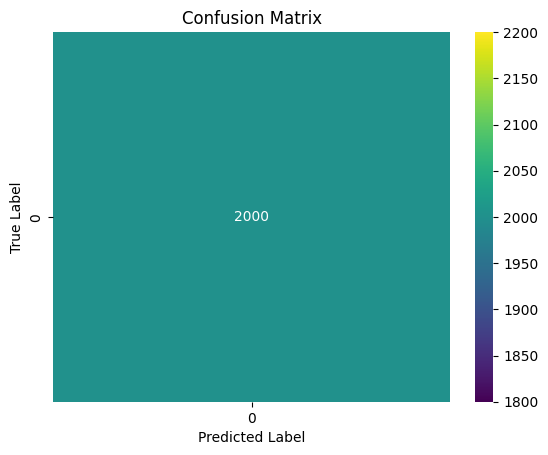

In [23]:
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [25]:
y_pred

array([[4.0363150e-07, 1.9475975e-12, 9.9999958e-01],
       [7.7339601e-09, 2.2383102e-15, 9.9999994e-01],
       [6.8059824e-09, 1.9676757e-15, 9.9999994e-01],
       ...,
       [1.0270153e-08, 6.2239859e-16, 9.9999994e-01],
       [1.7744318e-08, 2.4946353e-15, 9.9999994e-01],
       [1.0286542e-08, 8.2919666e-16, 9.9999994e-01]], dtype=float32)

In [26]:
# Classification report
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00      2000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



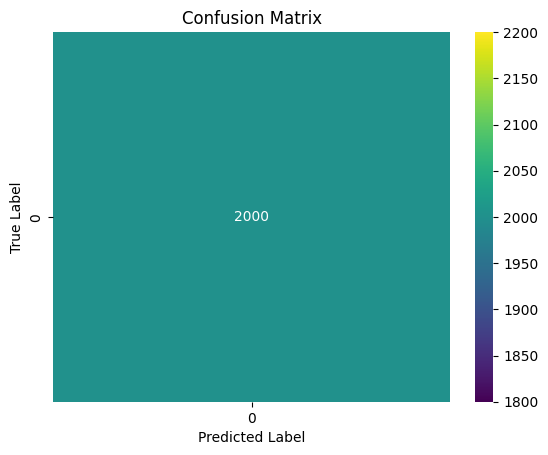

In [27]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [28]:
print('Confusion Matrix:')
print(cm)

Confusion Matrix:
[[2000]]


In [29]:
print("Deep Learning Model Performance:")
print(confusion_matrix(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes))

Deep Learning Model Performance:
[[2000]]
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00      2000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1664      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 12099 (47.26 KB)
Trainable params: 12099 (

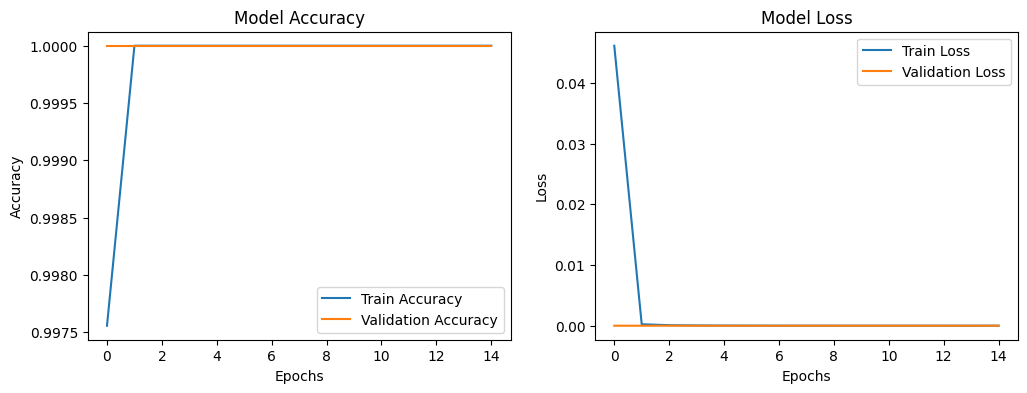

In [31]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
# Save the final model
model.save('final_model.keras')

In [33]:
# Save the training history
import json
history_dict = history.history
with open('history.json', 'w') as f:
    json.dump(history_dict, f)